# Non-Linear SVM

Classification of linearly inseparable data. We'll use the Iris dataset to build and train a non-linear SVM classifier to detect whether datapoints represent the Iris varieties. 

In [1]:
import numpy as np
from sklearn import datasets

## Tensorflow initialization

Let's import tensorflow and clear the default computational graph

In [2]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

## Session declaration

In [3]:
session = tf.Session()

## Load dataset

In [4]:
dataset = datasets.load_iris()

In [5]:
dataset.data[0:10]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1]])

In [6]:
dataset.data[0]

array([ 5.1,  3.5,  1.4,  0.2])

In [7]:
X = np.array([[X[0], X[3]] for X in dataset.data])

In [8]:
X[0:5]

array([[ 5.1,  0.2],
       [ 4.9,  0.2],
       [ 4.7,  0.2],
       [ 4.6,  0.2],
       [ 5. ,  0.2]])

In [9]:
y = np.array([1 if y == 0 else 0 for y in dataset.target])

In [10]:
y[0:5]

array([1, 1, 1, 1, 1])

## Set up model parameters, placeholder grids

In [11]:
batch_size = 200

# placeholder grids
X_grid = tf.placeholder(shape = [None, 2], dtype = tf.float32)
y_grid = tf.placeholder(shape = [None, 1], dtype = tf.float32)

In [12]:
# grid for predictions
prediction_grid = tf.placeholder(shape = [None, 2], dtype = tf.float32)

In [13]:
# b value for the SVM kernel
b = tf.Variable(tf.random_normal(shape = [1, batch_size]))

## Construct the RBF kernel

https://en.wikipedia.org/wiki/Radial_basis_function_kernel

### Gamma

The gamma is a constant for use in the RBF kernel that effectively determines the range of influence for a single subsample (ex: the raidus).

* Smaller values for gamme increase that relative influence, producing a wider kernel
* Larger values decrease the influence of a subsample, producing "tighter" looking decision boundaries

In [14]:
# tensorflow representation of the RBF kernel (gamme is negative)
gamma = tf.constant(-45.0) # gamma is some constant, which we made negative
sq_vec = tf.multiply(2., tf.matmul(X_grid, tf.transpose(X_grid)))
rbf_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

## Computational step

The non-linear SVM actually aims at maximizing the loss function, specifically by minimizing its negative:

In [15]:
first = tf.reduce_sum(b)
b_cross = tf.matmul(tf.transpose(b), b)
y_grid_cross = tf.matmul(y_grid, tf.transpose(y_grid))
second = tf.reduce_sum(tf.multiply(rbf_kernel, tf.multiply(b_cross, y_grid_cross)))

In [16]:
# loss is negative here because this value needs to be maximized
# minimizing a negative maximizes the positive equivalent
loss = tf.negative(tf.subtract(first, second))

## Build and apply a prediction kernel

In [17]:
rA = tf.reshape(tf.reduce_sum(tf.square(X_grid), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])

In [18]:
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(X_grid, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [19]:
pred_output = tf.matmul(tf.multiply(tf.transpose(y_grid), b), pred_kernel)
prediction = tf.sign(pred_output - tf.reduce_mean(pred_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_grid)), tf.float32))

## Declare optimizer function, train step

Next, we need to declare an optimizer function to train the classifier. We'll se a GradientDescentOptimizer from tensorflow.train. Furthermore, we aim to train the model by minimizing the loss function. This informs our definition for train_step below. 

In [20]:
# initialize gradient descent optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01) # learning rate of 0.01

# define training step
train_step = optimizer.minimize(loss)

## Training preparation: global variables and loop parameters

In [21]:
# initialize the global variables 
init = tf.global_variables_initializer()
session.run(init)

In [22]:
# loop parameters/variables
num_iter = 300

## Training the model

In [25]:
# training loop
for i in range(num_iter):
    rand_index = np.random.choice(len(X), size = batch_size)
    rand_X = X[rand_index]
    rand_y = np.transpose([y[rand_index]])
    session.run(train_step, feed_dict = {X_grid: rand_X, y_grid: rand_y})
    
    # Confirm that our loss values are actually decreasing
    temp_loss = session.run(loss, feed_dict = {X_grid: rand_X, y_grid: rand_y})
    
    if (i + 1) % 50 == 0:
        print("Loss @ step", str(i + 1), "=", str(temp_loss))

Loss @ step 50 = -79.4829
Loss @ step 100 = -179.483
Loss @ step 150 = -279.483
Loss @ step 200 = -379.483
Loss @ step 250 = -479.483
Loss @ step 300 = -579.483


Coolio - the loss minimizer is working!

## Visualizing the clasifier: grid construction

In [27]:
import matplotlib.pyplot as plt

# construct numpy mesh for plotting
X_min, X_max = X[:, 0].min() -1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(X_min, X_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]

[grid_predictions] = session.run(prediction, feed_dict = {X_grid: rand_X, y_grid: rand_y, prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)

## Pulling per class data from feature data

In [29]:
# pulling out sepal width and legnth for each class for plotting

X1 = [x[0] for i, x in enumerate(X) if y[i] == 1]
y1 = [x[1] for i, x in enumerate(X) if y[i] == 1]

X2 = [x[0] for i, x in enumerate(X) if y[i] == 0]
y2 = [x[1] for i, x in enumerate(X) if y[i] == 0]

## Plotting the results

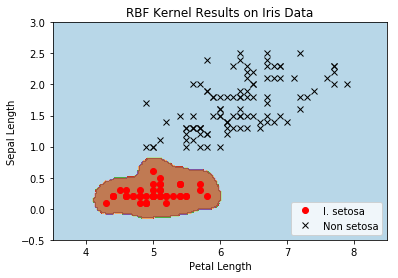

In [30]:
%matplotlib inline

plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.8)
plt.plot(X1, y1, "ro", label = "I. setosa")
plt.plot(X2, y2, "kx", label = "Non setosa")

plt.title("RBF Kernel Results on Iris Data")
plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")

plt.legend(loc = "lower right")

plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])

plt.show()

The classififer is able to differentiate between I Setosa and other varieties! The decision boundary is a curve. For each support vector selected, an ellipsoid is projected out with it at the center. The overlap of the hyper-ellipsoids forms the decision boundaries. 